In [9]:
from pyspark.sql import SparkSession

#start session 
spark_session = SparkSession.builder.appName("VCF_test")\
.config ("spark.sql.shuffle.partitions", "50")\
.config("spark.driver.maxResultSize","5g")\
.config ("spark.sql.execution.arrow.enabled", "true")\
.getOrCreate()

spark_context = spark_session.sparkContext

In [10]:
vcf = spark_context.textFile("File:///home/ubuntu/LDSA--Project/test.vcf")
vcf.take(20)

['##fileformat=VCFv4.2',
 '##fileDate=20090805',
 '##source=myImputationProgramV3.1',
 '##reference=file:///seq/references/1000GenomesPilot-NCBI36.fasta',
 '##contig=<ID=20,length=62435964,assembly=B36,md5=f126cdf8a6e0c7f379d618ff66beb2da,species="Homo sapiens",taxonomy=x>',
 '##phasing=partial',
 '##INFO=<ID=NS,Number=1,Type=Integer,Description="Number of Samples With Data">',
 '##INFO=<ID=DP,Number=1,Type=Integer,Description="Total Depth">',
 '##INFO=<ID=AF,Number=A,Type=Float,Description="Allele Frequency">',
 '##INFO=<ID=AA,Number=1,Type=String,Description="Ancestral Allele">',
 '##INFO=<ID=DB,Number=0,Type=Flag,Description="dbSNP membership, build 129">',
 '##INFO=<ID=H2,Number=0,Type=Flag,Description="HapMap2 membership">',
 '##FILTER=<ID=q10,Description="Quality below 10">',
 '##FILTER=<ID=s50,Description="Less than 50% of samples have data">',
 '##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">',
 '##FORMAT=<ID=GQ,Number=1,Type=Integer,Description="Genotype Quality">

In [11]:
#remove rows that start with ## 
vcf = vcf.filter(lambda line : not  line.startswith('t=VCF'))\
    .filter(lambda line : not line.startswith('##'))\
    .map(lambda line : line.split())
vcf.take(100)

[['#CHROM',
  'POS',
  'ID',
  'REF',
  'ALT',
  'QUAL',
  'FILTER',
  'INFO',
  'FORMAT',
  'NA00001',
  'NA00002',
  'NA00003'],
 ['20',
  '14370',
  'rs6054257',
  'G',
  'A',
  '29',
  'PASS',
  'NS=3;DP=14;AF=0.5;DB;H2',
  'GT:GQ:DP:HQ',
  '0|0:48:1:51,51',
  '1|0:48:8:51,51',
  '1/1:43:5:.,.'],
 ['20',
  '17330',
  '.',
  'T',
  'A',
  '3',
  'q10',
  'NS=3;DP=11;AF=0.017',
  'GT:GQ:DP:HQ',
  '0|0:49:3:58,50',
  '0|1:3:5:65,3',
  '0/0:41:3'],
 ['20',
  '1110696',
  'rs6040355',
  'A',
  'G,T',
  '67',
  'PASS',
  'NS=2;DP=10;AF=0.333,0.667;AA=T;DB',
  'GT:GQ:DP:HQ',
  '1|2:21:6:23,27',
  '2|1:2:0:18,2',
  '2/2:35:4'],
 ['20',
  '1230237',
  '.',
  'T',
  '.',
  '47',
  'PASS',
  'NS=3;DP=13;AA=T',
  'GT:GQ:DP:HQ',
  '0|0:54:7:56,60',
  '0|0:48:4:51,51',
  '0/0:61:2'],
 ['20',
  '1234567',
  'microsat1',
  'GTC',
  'G,GTCT',
  '50',
  'PASS',
  'NS=3;DP=9;AA=G',
  'GT:GQ:DP',
  '0/1:35:4',
  '0/2:17:2',
  '1/1:40:3']]

In [12]:
#create df with header 
vcf = vcf.toDF(schema = vcf.first()) 
vcf = vcf.filter(vcf["#CHROM"]!="#CHROM")
vcf.show()

+------+-------+---------+---+------+----+------+--------------------+-----------+--------------+--------------+------------+
|#CHROM|    POS|       ID|REF|   ALT|QUAL|FILTER|                INFO|     FORMAT|       NA00001|       NA00002|     NA00003|
+------+-------+---------+---+------+----+------+--------------------+-----------+--------------+--------------+------------+
|    20|  14370|rs6054257|  G|     A|  29|  PASS|NS=3;DP=14;AF=0.5...|GT:GQ:DP:HQ|0|0:48:1:51,51|1|0:48:8:51,51|1/1:43:5:.,.|
|    20|  17330|        .|  T|     A|   3|   q10| NS=3;DP=11;AF=0.017|GT:GQ:DP:HQ|0|0:49:3:58,50|  0|1:3:5:65,3|    0/0:41:3|
|    20|1110696|rs6040355|  A|   G,T|  67|  PASS|NS=2;DP=10;AF=0.3...|GT:GQ:DP:HQ|1|2:21:6:23,27|  2|1:2:0:18,2|    2/2:35:4|
|    20|1230237|        .|  T|     .|  47|  PASS|     NS=3;DP=13;AA=T|GT:GQ:DP:HQ|0|0:54:7:56,60|0|0:48:4:51,51|    0/0:61:2|
|    20|1234567|microsat1|GTC|G,GTCT|  50|  PASS|      NS=3;DP=9;AA=G|   GT:GQ:DP|      0/1:35:4|      0/2:17:2|    1/

In [13]:
from pyspark.sql.types import *

#Make POS and QUAL integer, filter on QUAL 
vcf = vcf.withColumn("POS", vcf["POS"].cast(IntegerType()))\
        .withColumn('QUAL', vcf['QUAL'].cast(IntegerType()))\
        .filter(vcf['QUAL'] > 20)
vcf.printSchema()

root
 |-- #CHROM: string (nullable = true)
 |-- POS: integer (nullable = true)
 |-- ID: string (nullable = true)
 |-- REF: string (nullable = true)
 |-- ALT: string (nullable = true)
 |-- QUAL: integer (nullable = true)
 |-- FILTER: string (nullable = true)
 |-- INFO: string (nullable = true)
 |-- FORMAT: string (nullable = true)
 |-- NA00001: string (nullable = true)
 |-- NA00002: string (nullable = true)
 |-- NA00003: string (nullable = true)



In [15]:
vcf.sample(False, 0.5, 123).show()

+------+-------+---------+---+------+----+------+--------------------+-----------+--------------+--------------+--------+
|#CHROM|    POS|       ID|REF|   ALT|QUAL|FILTER|                INFO|     FORMAT|       NA00001|       NA00002| NA00003|
+------+-------+---------+---+------+----+------+--------------------+-----------+--------------+--------------+--------+
|    20|1110696|rs6040355|  A|   G,T|  67|  PASS|NS=2;DP=10;AF=0.3...|GT:GQ:DP:HQ|1|2:21:6:23,27|  2|1:2:0:18,2|2/2:35:4|
|    20|1230237|        .|  T|     .|  47|  PASS|     NS=3;DP=13;AA=T|GT:GQ:DP:HQ|0|0:54:7:56,60|0|0:48:4:51,51|0/0:61:2|
|    20|1234567|microsat1|GTC|G,GTCT|  50|  PASS|      NS=3;DP=9;AA=G|   GT:GQ:DP|      0/1:35:4|      0/2:17:2|1/1:40:3|
+------+-------+---------+---+------+----+------+--------------------+-----------+--------------+--------------+--------+



In [6]:
import re 
from pyspark.sql.functions import col, split

#Get names of sample columns 
columns = vcf.schema.names
columns = [x for x in columns if re.match("NA*", x)]

for sample in columns: 
    vcf = vcf.withColumn(sample, split(col(sample), ":").cast(ArrayType(StringType())).alias(sample)[0])
    
vcf.select('POS', 'ALT', 'QUAL', 'FORMAT', 'NA00001').show()

+-------+------+----+-----------+-------+
|    POS|   ALT|QUAL|     FORMAT|NA00001|
+-------+------+----+-----------+-------+
|  14370|     A|  29|GT:GQ:DP:HQ|    0|0|
|1110696|   G,T|  67|GT:GQ:DP:HQ|    1|2|
|1230237|     .|  47|GT:GQ:DP:HQ|    0|0|
|1234567|G,GTCT|  50|   GT:GQ:DP|    0/1|
+-------+------+----+-----------+-------+



In [7]:
vcf = vcf.union(vcf)
vcf.show()

+------+-------+---------+---+------+----+------+--------------------+-----------+-------+-------+-------+
|#CHROM|    POS|       ID|REF|   ALT|QUAL|FILTER|                INFO|     FORMAT|NA00001|NA00002|NA00003|
+------+-------+---------+---+------+----+------+--------------------+-----------+-------+-------+-------+
|    20|  14370|rs6054257|  G|     A|  29|  PASS|NS=3;DP=14;AF=0.5...|GT:GQ:DP:HQ|    0|0|    1|0|    1/1|
|    20|1110696|rs6040355|  A|   G,T|  67|  PASS|NS=2;DP=10;AF=0.3...|GT:GQ:DP:HQ|    1|2|    2|1|    2/2|
|    20|1230237|        .|  T|     .|  47|  PASS|     NS=3;DP=13;AA=T|GT:GQ:DP:HQ|    0|0|    0|0|    0/0|
|    20|1234567|microsat1|GTC|G,GTCT|  50|  PASS|      NS=3;DP=9;AA=G|   GT:GQ:DP|    0/1|    0/2|    1/1|
|    20|  14370|rs6054257|  G|     A|  29|  PASS|NS=3;DP=14;AF=0.5...|GT:GQ:DP:HQ|    0|0|    1|0|    1/1|
|    20|1110696|rs6040355|  A|   G,T|  67|  PASS|NS=2;DP=10;AF=0.3...|GT:GQ:DP:HQ|    1|2|    2|1|    2/2|
|    20|1230237|        .|  T|     .|

In [24]:
from pyspark.sql.functions import concat
import re 

#Concatenate the genotype columns to one column 
vcf = vcf.withColumn('GENOTYPES',concat(*columns))

#drop the sample columns 
vcf = vcf.drop(*columns) 

vcf.show()

+------+-------+---------+---+------+----+------+--------------------+-----------+---------+
|#CHROM|    POS|       ID|REF|   ALT|QUAL|FILTER|                INFO|     FORMAT|GENOTYPES|
+------+-------+---------+---+------+----+------+--------------------+-----------+---------+
|    20|  14370|rs6054257|  G|     A|  29|  PASS|NS=3;DP=14;AF=0.5...|GT:GQ:DP:HQ|0|01|01/1|
|    20|1110696|rs6040355|  A|   G,T|  67|  PASS|NS=2;DP=10;AF=0.3...|GT:GQ:DP:HQ|1|22|12/2|
|    20|1230237|        .|  T|     .|  47|  PASS|     NS=3;DP=13;AA=T|GT:GQ:DP:HQ|0|00|00/0|
|    20|1234567|microsat1|GTC|G,GTCT|  50|  PASS|      NS=3;DP=9;AA=G|   GT:GQ:DP|0/10/21/1|
+------+-------+---------+---+------+----+------+--------------------+-----------+---------+



In [37]:
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf, struct
import re 

def count_allel(GENOTYPES, ALT):
    #get number of allels 
    n = re.findall('[ATGC.]+', ALT)
    res = []
    for i in range(0,len(n)+1):
        res.append(GENOTYPES.count(str(i)))
    return res

count_allel_udf = udf(count_allel, StringType())

vcf = vcf.withColumn('ALLEL_FREQ', count_allel_udf('GENOTYPES', 'ALT'))
vcf.show()

+------+-------+---------+---+------+----+------+--------------------+-----------+---------+-----------+----------+
|#CHROM|    POS|       ID|REF|   ALT|QUAL|FILTER|                INFO|     FORMAT|GENOTYPES|ALLEL_COUNT|ALLEL_FREQ|
+------+-------+---------+---+------+----+------+--------------------+-----------+---------+-----------+----------+
|    20|  14370|rs6054257|  G|     A|  29|  PASS|NS=3;DP=14;AF=0.5...|GT:GQ:DP:HQ|0|01|01/1|     [3, 3]|    [3, 3]|
|    20|1110696|rs6040355|  A|   G,T|  67|  PASS|NS=2;DP=10;AF=0.3...|GT:GQ:DP:HQ|1|22|12/2|  [0, 2, 4]| [0, 2, 4]|
|    20|1230237|        .|  T|     .|  47|  PASS|     NS=3;DP=13;AA=T|GT:GQ:DP:HQ|0|00|00/0|     [6, 0]|    [6, 0]|
|    20|1234567|microsat1|GTC|G,GTCT|  50|  PASS|      NS=3;DP=9;AA=G|   GT:GQ:DP|0/10/21/1|  [2, 3, 1]| [2, 3, 1]|
+------+-------+---------+---+------+----+------+--------------------+-----------+---------+-----------+----------+



In [47]:
#Calculate Nd
def Nd(ALLEL_FREQ):
    sqrd = [x**2 for x in ALLEL_FREQ]
    diff = [x-y for x, y in zip(sqrd, ALLEL_FREQ)]
    return sum(diff)/((sum(ALLEL_FREQ)**2)-sum(ALLEL_FREQ))
    
Nd_udf = udf(Nd, StringType())

vcf = vcf.withColumn('Nd', Nd_udf('ALLEL_FREQ'))
vcf.select('Nd').show()  


+-------------------+
|                 Nd|
+-------------------+
|                0.4|
| 0.4666666666666667|
|                1.0|
|0.26666666666666666|
+-------------------+



In [ ]:
from pyspark.sql.functions import sum

vcf_sum = vcf.withColumn('Nd', 1- vcf_sum['sum(ALLEL_FREQ_SQRD_DIFF)']/((vcf_sum['sum(ALLEL_FREQ)']**2)-vcf_sum['sum(ALLEL_FREQ_SQRD_DIFF)']))
    
vcf_sum.show()

In [6]:
from pyspark.sql.functions import split, explode

#split rows so that ecah row only has one alternative allel in ALT 
vcf = vcf.withColumn('ALT_SPLIT',explode(split('ALT',',')))
vcf.show()

+------+-------+---------+---+------+----+------+--------------------+-----------+--------------+--------------+------------+---------+
|#CHROM|    POS|       ID|REF|   ALT|QUAL|FILTER|                INFO|     FORMAT|       NA00001|       NA00002|     NA00003|ALT_SPLIT|
+------+-------+---------+---+------+----+------+--------------------+-----------+--------------+--------------+------------+---------+
|    20|  14370|rs6054257|  G|     A|  29|  PASS|NS=3;DP=14;AF=0.5...|GT:GQ:DP:HQ|0|0:48:1:51,51|1|0:48:8:51,51|1/1:43:5:.,.|        A|
|    20|1110696|rs6040355|  A|   G,T|  67|  PASS|NS=2;DP=10;AF=0.3...|GT:GQ:DP:HQ|1|2:21:6:23,27|  2|1:2:0:18,2|    2/2:35:4|        G|
|    20|1110696|rs6040355|  A|   G,T|  67|  PASS|NS=2;DP=10;AF=0.3...|GT:GQ:DP:HQ|1|2:21:6:23,27|  2|1:2:0:18,2|    2/2:35:4|        T|
|    20|1230237|        .|  T|     .|  47|  PASS|     NS=3;DP=13;AA=T|GT:GQ:DP:HQ|0|0:54:7:56,60|0|0:48:4:51,51|    0/0:61:2|        .|
|    20|1234567|microsat1|GTC|G,GTCT|  50|  PASS

In [7]:
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf, struct
import re 

#Get the index of the allele from ALT_SPLIT and ALT 
def index_allel(ALT, ALT_SPLIT):
    res = re.findall('[ATGC.]+', ALT)
    regex = re.compile(rf'^{ALT_SPLIT}$')
    idx = [i+1 for i, item in enumerate(res) if re.search(regex, item)]
    return idx[0]

index_allel_udf = udf(index_allel, StringType())

vcf = vcf.withColumn('INDEX_ALLEL', index_allel_udf('ALT', 'ALT_SPLIT'))

vcf.select('POS', 'INDEX_ALLEL', 'ALT', 'ALT_SPLIT', 'QUAL', 'FORMAT', 'NA00001').show()

+-------+-----------+------+---------+----+-----------+--------------+
|    POS|INDEX_ALLEL|   ALT|ALT_SPLIT|QUAL|     FORMAT|       NA00001|
+-------+-----------+------+---------+----+-----------+--------------+
|  14370|          1|     A|        A|  29|GT:GQ:DP:HQ|0|0:48:1:51,51|
|1110696|          1|   G,T|        G|  67|GT:GQ:DP:HQ|1|2:21:6:23,27|
|1110696|          2|   G,T|        T|  67|GT:GQ:DP:HQ|1|2:21:6:23,27|
|1230237|          1|     .|        .|  47|GT:GQ:DP:HQ|0|0:54:7:56,60|
|1234567|          1|G,GTCT|        G|  50|   GT:GQ:DP|      0/1:35:4|
|1234567|          2|G,GTCT|     GTCT|  50|   GT:GQ:DP|      0/1:35:4|
+-------+-----------+------+---------+----+-----------+--------------+



In [8]:
import re 
from pyspark.sql.functions import col

#Get names of sample columns 
columns = vcf.schema.names
columns = [x for x in columns if re.match("NA*", x)]

for sample in columns: 
    vcf = vcf.withColumn(sample, split(col(sample), ":").cast(ArrayType(StringType())).alias(sample)[0])
    
vcf.select('POS', 'INDEX_ALLEL', 'ALT', 'ALT_SPLIT', 'QUAL', 'FORMAT', 'NA00001').show()

+-------+-----------+------+---------+----+-----------+-------+
|    POS|INDEX_ALLEL|   ALT|ALT_SPLIT|QUAL|     FORMAT|NA00001|
+-------+-----------+------+---------+----+-----------+-------+
|  14370|          1|     A|        A|  29|GT:GQ:DP:HQ|    0|0|
|1110696|          1|   G,T|        G|  67|GT:GQ:DP:HQ|    1|2|
|1110696|          2|   G,T|        T|  67|GT:GQ:DP:HQ|    1|2|
|1230237|          1|     .|        .|  47|GT:GQ:DP:HQ|    0|0|
|1234567|          1|G,GTCT|        G|  50|   GT:GQ:DP|    0/1|
|1234567|          2|G,GTCT|     GTCT|  50|   GT:GQ:DP|    0/1|
+-------+-----------+------+---------+----+-----------+-------+



In [12]:
#count number of times each allel occurs 
def count_allel(sample, INDEX_ALLEL):
    return sample.count(INDEX_ALLEL)
    
count_allel_udf = udf(count_allel, StringType())

for sample in columns:
    vcf = vcf.withColumn(sample, count_allel_udf(sample, 'INDEX_ALLEL'))

vcf.select('POS', 'ALT', 'ALT_SPLIT', 'INDEX_ALLEL', 'NA00001', 'NA00002', 'NA00003').show()


+-------+------+---------+-----------+-------+-------+-------+
|    POS|   ALT|ALT_SPLIT|INDEX_ALLEL|NA00001|NA00002|NA00003|
+-------+------+---------+-----------+-------+-------+-------+
|  14370|     A|        A|          1|      0|      1|      0|
|1110696|   G,T|        G|          1|      1|      1|      0|
|1110696|   G,T|        T|          2|      0|      0|      1|
|1230237|     .|        .|          1|      0|      0|      0|
|1234567|G,GTCT|        G|          1|      1|      0|      0|
|1234567|G,GTCT|     GTCT|          2|      0|      0|      0|
+-------+------+---------+-----------+-------+-------+-------+



In [14]:
from pyspark.sql.functions import pow, col
import re 

#Calculate frequency and frequency squared 
vcf = vcf.withColumn('ALLEL_FREQ', sum(vcf[sample] for sample in columns))\
         .withColumn('ALLEL_FREQ_SQRD', pow(col("ALLEL_FREQ"), 2))

#Calculate frequency minus frequency squared 
vcf = vcf.withColumn('ALLEL_FREQ_SQRD_DIFF', (vcf["ALLEL_FREQ"]-vcf["ALLEL_FREQ_SQRD"]))

#vcf = vcf.drop('ALLEL_FREQ', 'ALLEL_FREQ_SQRD', 'ALLEL_FREQ_SQRD_DIFF', 'test')
vcf.printSchema()
vcf.select('POS', 'ALLEL_FREQ', 'ALLEL_FREQ_SQRD', 'ALLEL_FREQ_SQRD_DIFF').show()

root
 |-- #CHROM: string (nullable = true)
 |-- POS: integer (nullable = true)
 |-- ID: string (nullable = true)
 |-- REF: string (nullable = true)
 |-- ALT: string (nullable = true)
 |-- QUAL: integer (nullable = true)
 |-- FILTER: string (nullable = true)
 |-- INFO: string (nullable = true)
 |-- FORMAT: string (nullable = true)
 |-- NA00001: string (nullable = true)
 |-- NA00002: string (nullable = true)
 |-- NA00003: string (nullable = true)
 |-- ALT_SPLIT: string (nullable = true)
 |-- INDEX_ALLEL: string (nullable = true)
 |-- ALLEL_FREQ: double (nullable = true)
 |-- ALLEL_FREQ_SQRD: double (nullable = true)
 |-- ALLEL_FREQ_SQRD_DIFF: double (nullable = true)

+-------+----------+---------------+--------------------+
|    POS|ALLEL_FREQ|ALLEL_FREQ_SQRD|ALLEL_FREQ_SQRD_DIFF|
+-------+----------+---------------+--------------------+
|  14370|       1.0|            1.0|                 0.0|
|1110696|       2.0|            4.0|                -2.0|
|1110696|       1.0|            1.0

In [15]:
from pyspark.sql.functions import sum

vcf_sum = vcf.groupBy('POS')\
            .agg(sum("ALLEL_FREQ"), sum('ALLEL_FREQ_SQRD_DIFF'))

vcf_sum = vcf_sum.withColumn('Nd', 1- vcf_sum['sum(ALLEL_FREQ_SQRD_DIFF)']/((vcf_sum['sum(ALLEL_FREQ)']**2)-vcf_sum['sum(ALLEL_FREQ_SQRD_DIFF)']))
    
vcf_sum.show()

+-------+---------------+-------------------------+------------------+
|    POS|sum(ALLEL_FREQ)|sum(ALLEL_FREQ_SQRD_DIFF)|                Nd|
+-------+---------------+-------------------------+------------------+
|1234567|            1.0|                      0.0|               1.0|
|1230237|            0.0|                      0.0|              null|
|1110696|            3.0|                     -2.0|1.1818181818181819|
|  14370|            1.0|                      0.0|               1.0|
+-------+---------------+-------------------------+------------------+



In [16]:
from pyspark.ml.feature import Bucketizer

#define the splits (use min max values from POS argument...) 
splits = list(range(0, 57227415, 1000))
bucketizer = Bucketizer(splits=splits, inputCol="POS", outputCol="POS_BUCKET")

#Transform original data into bucket index
vcf_sum = bucketizer.transform(vcf_sum)

vcf_sum.show()

+-------+---------------+-------------------------+------------------+----------+
|    POS|sum(ALLEL_FREQ)|sum(ALLEL_FREQ_SQRD_DIFF)|                Nd|POS_BUCKET|
+-------+---------------+-------------------------+------------------+----------+
|1234567|            1.0|                      0.0|               1.0|    1234.0|
|1230237|            0.0|                      0.0|              null|    1230.0|
|1110696|            3.0|                     -2.0|1.1818181818181819|    1110.0|
|  14370|            1.0|                      0.0|               1.0|      14.0|
+-------+---------------+-------------------------+------------------+----------+



In [17]:
#Calculate nucleotide diversity per baspair 
vcf_sum = vcf_sum.groupBy('POS_BUCKET')\
                .agg(sum('Nd'))\
                .orderBy('POS_BUCKET')
                
vcf_sum = vcf_sum.withColumn('Nd/bp', vcf_sum['sum(Nd)']/1000)

vcf_sum.show()

+----------+------------------+--------------------+
|POS_BUCKET|           sum(Nd)|               Nd/bp|
+----------+------------------+--------------------+
|      14.0|               1.0|               0.001|
|    1110.0|1.1818181818181819|0.001181818181818...|
|    1230.0|              null|                null|
|    1234.0|               1.0|               0.001|
+----------+------------------+--------------------+



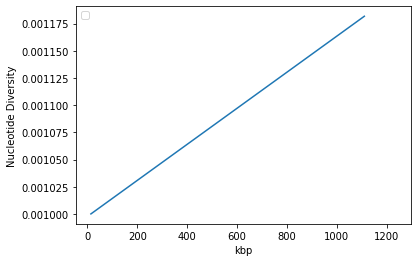

In [19]:
#plot
import matplotlib.pyplot as plt

y = vcf_sum.select('Nd/bp').collect()
x = vcf_sum.select('POS_BUCKET').collect()

plt.plot(x, y)

plt.ylabel('Nucleotide Diversity')
plt.xlabel('kbp')
plt.title('')
plt.legend('', loc='upper left')

plt.show()

In [20]:
spark_context.stop()

### NUMBER OF PLYMORPHIC SITES 

In [7]:
#count number of rows in each bucket 
vcf_count = vcf.groupby('POS_BUCKET')\
    .agg({'POS': 'count'})

vcf_count.show()

+----------+----------+
|POS_BUCKET|count(POS)|
+----------+----------+
|    1230.0|         1|
|    1234.0|         1|
|      14.0|         1|
|    1110.0|         1|
|      17.0|         1|
+----------+----------+



In [8]:
import matplotlib.pyplot as plt

y = vcf_count.select('count(POS)').collect()
x = vcf_count.select('POS_BUCKET').collect()

plt.plot(x, y)

plt.ylabel('Plymorphic Sites')
plt.xlabel('kbp')
plt.title('')
plt.legend('', loc='upper left')

plt.show()

<Figure size 640x480 with 1 Axes>

# NUCLEOTIDE DIVERSITY 

In [9]:
#try haplotype diversity instead 
vcf.show()

+------+-------+---------+---+------+----+------+--------------------+-----------+--------------+--------------+------------+----------+
|#CHROM|    POS|       ID|REF|   ALT|QUAL|FILTER|                INFO|     FORMAT|       NA00001|       NA00002|     NA00003|POS_BUCKET|
+------+-------+---------+---+------+----+------+--------------------+-----------+--------------+--------------+------------+----------+
|    20|  14370|rs6054257|  G|     A|  29|  PASS|NS=3;DP=14;AF=0.5...|GT:GQ:DP:HQ|0|0:48:1:51,51|1|0:48:8:51,51|1/1:43:5:.,.|      14.0|
|    20|  17330|        .|  T|     A|   3|   q10| NS=3;DP=11;AF=0.017|GT:GQ:DP:HQ|0|0:49:3:58,50|  0|1:3:5:65,3|    0/0:41:3|      17.0|
|    20|1110696|rs6040355|  A|   G,T|  67|  PASS|NS=2;DP=10;AF=0.3...|GT:GQ:DP:HQ|1|2:21:6:23,27|  2|1:2:0:18,2|    2/2:35:4|    1110.0|
|    20|1230237|        .|  T|     .|  47|  PASS|     NS=3;DP=13;AA=T|GT:GQ:DP:HQ|0|0:54:7:56,60|0|0:48:4:51,51|    0/0:61:2|    1230.0|
|    20|1234567|microsat1|GTC|G,GTCT|  50

Calculate haplotype diversity: 
1. relative frequency of each haplotype: Hf = Hj / N where Hj is number of times haplotype j occurs and N number of individuals/sequences in the dataset  
2. haplotype diversity: Hd = N/N-1 * (1 - sum(Hf^2)) (for each haplotype in the window) -> fråga nån som kan matte!!!!

todo: 
1. for rows with more than one alternative allel: split so one allel per row 
2. transform the genotype values to numeric 

In [10]:
from pyspark.sql.functions import split, explode

#split rows so that ecah row only has one alternative allel in ALT 
vcf_split = vcf.withColumn('ALT_SPLIT',explode(split('ALT',',')))
vcf_split.show()

+------+-------+---------+---+------+----+------+--------------------+-----------+--------------+--------------+------------+----------+---------+
|#CHROM|    POS|       ID|REF|   ALT|QUAL|FILTER|                INFO|     FORMAT|       NA00001|       NA00002|     NA00003|POS_BUCKET|ALT_SPLIT|
+------+-------+---------+---+------+----+------+--------------------+-----------+--------------+--------------+------------+----------+---------+
|    20|  14370|rs6054257|  G|     A|  29|  PASS|NS=3;DP=14;AF=0.5...|GT:GQ:DP:HQ|0|0:48:1:51,51|1|0:48:8:51,51|1/1:43:5:.,.|      14.0|        A|
|    20|  17330|        .|  T|     A|   3|   q10| NS=3;DP=11;AF=0.017|GT:GQ:DP:HQ|0|0:49:3:58,50|  0|1:3:5:65,3|    0/0:41:3|      17.0|        A|
|    20|1110696|rs6040355|  A|   G,T|  67|  PASS|NS=2;DP=10;AF=0.3...|GT:GQ:DP:HQ|1|2:21:6:23,27|  2|1:2:0:18,2|    2/2:35:4|    1110.0|        G|
|    20|1110696|rs6040355|  A|   G,T|  67|  PASS|NS=2;DP=10;AF=0.3...|GT:GQ:DP:HQ|1|2:21:6:23,27|  2|1:2:0:18,2|    2/

In [11]:
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf, struct
import re 

def index_allel(ALT, ALT_SPLIT):
    res = re.findall('[ATGC.]+', ALT)
    regex = re.compile(rf'^{ALT_SPLIT}$')
    idx = [i+1 for i, item in enumerate(res) if re.search(regex, item)]
    return idx[0]

index_allel_udf = udf(index_allel, StringType())

vcf_split = vcf_split.withColumn('INDEX_ALLEL', index_allel_udf('ALT', 'ALT_SPLIT'))

vcf_split.select('ALT', 'ALT_SPLIT', 'INDEX_ALLEL').show()

+------+---------+-----------+
|   ALT|ALT_SPLIT|INDEX_ALLEL|
+------+---------+-----------+
|     A|        A|          1|
|     A|        A|          1|
|   G,T|        G|          1|
|   G,T|        T|          2|
|     .|        .|          1|
|G,GTCT|        G|          1|
|G,GTCT|     GTCT|          2|
+------+---------+-----------+



In [12]:
import re 
from pyspark.sql.functions import udf

#Get names of sample columns 
columns = vcf.schema.names
columns = [x for x in columns if re.match("NA*", x)]

#function that gets GT (genotype) part of sample information 
def get_genotypes(sample):
    res = sample.split(':')[0]
    res = re.findall('[0-9]', res)
    return res 

#udf 
udf_get_genotypes = udf(get_genotypes, StringType())

#loop through samples 
for sample in columns: 
    vcf_split = vcf_split.withColumn(sample, udf_get_genotypes(sample))
    
vcf_split.select('ALT', 'ALT_SPLIT', 'INDEX_ALLEL', 'NA00001', 'NA00002', 'NA00003').show()


+------+---------+-----------+-------+-------+-------+
|   ALT|ALT_SPLIT|INDEX_ALLEL|NA00001|NA00002|NA00003|
+------+---------+-----------+-------+-------+-------+
|     A|        A|          1| [0, 0]| [1, 0]| [1, 1]|
|     A|        A|          1| [0, 0]| [0, 1]| [0, 0]|
|   G,T|        G|          1| [1, 2]| [2, 1]| [2, 2]|
|   G,T|        T|          2| [1, 2]| [2, 1]| [2, 2]|
|     .|        .|          1| [0, 0]| [0, 0]| [0, 0]|
|G,GTCT|        G|          1| [0, 1]| [0, 2]| [1, 1]|
|G,GTCT|     GTCT|          2| [0, 1]| [0, 2]| [1, 1]|
+------+---------+-----------+-------+-------+-------+



In [13]:
#count number of times each allel occurs 
def count_allel(sample, INDEX_ALLEL):
    return sample.count(INDEX_ALLEL)
    
count_allel_udf = udf(count_allel, StringType())

for sample in columns:
    vcf_split = vcf_split.withColumn(sample, count_allel_udf(sample, 'INDEX_ALLEL'))

vcf_split.select('POS', 'ALT', 'ALT_SPLIT', 'INDEX_ALLEL', 'NA00001', 'NA00002', 'NA00003').show()


+-------+------+---------+-----------+-------+-------+-------+
|    POS|   ALT|ALT_SPLIT|INDEX_ALLEL|NA00001|NA00002|NA00003|
+-------+------+---------+-----------+-------+-------+-------+
|  14370|     A|        A|          1|      0|      1|      2|
|  17330|     A|        A|          1|      0|      1|      0|
|1110696|   G,T|        G|          1|      1|      1|      0|
|1110696|   G,T|        T|          2|      1|      1|      2|
|1230237|     .|        .|          1|      0|      0|      0|
|1234567|G,GTCT|        G|          1|      1|      0|      2|
|1234567|G,GTCT|     GTCT|          2|      0|      1|      0|
+-------+------+---------+-----------+-------+-------+-------+



In [22]:
from pyspark.sql.functions import pow, col

#Calculate frequency and 
vcf_freq = vcf_split.withColumn('ALLEL_FREQ', sum(vcf_split[sample] for sample in columns))\
                    .withColumn('ALLEL_FREQ_SQRD', pow(col("ALLEL_FREQ"), 2).alias("ALLEL_FREQ_SQRD"))
                    
vcf_freq = vcf_freq.withColumn('ALLEL_FREQ_SQRD_DIFF', (vcf_freq["ALLEL_FREQ"]-vcf_freq["ALLEL_FREQ_SQRD"]))

vcf_freq.select('POS', 'ALLEL_FREQ', 'ALLEL_FREQ_SQRD', 'ALLEL_FREQ_SQRD_DIFF').show()

+-------+----------+---------------+--------------------+
|    POS|ALLEL_FREQ|ALLEL_FREQ_SQRD|ALLEL_FREQ_SQRD_DIFF|
+-------+----------+---------------+--------------------+
|  14370|       3.0|            9.0|                -6.0|
|  17330|       1.0|            1.0|                 0.0|
|1110696|       2.0|            4.0|                -2.0|
|1110696|       4.0|           16.0|               -12.0|
|1230237|       0.0|            0.0|                 0.0|
|1234567|       3.0|            9.0|                -6.0|
|1234567|       1.0|            1.0|                 0.0|
+-------+----------+---------------+--------------------+



In [34]:
from pyspark.sql.functions import sum

vcf_sum = vcf_freq.groupBy('POS')\
            .agg(sum("ALLEL_FREQ"), sum('ALLEL_FREQ_SQRD_DIFF'))
    
vcf_sum.show()

+-------+---------------+-------------------------+
|    POS|sum(ALLEL_FREQ)|sum(ALLEL_FREQ_SQRD_DIFF)|
+-------+---------------+-------------------------+
|  17330|            1.0|                      0.0|
|1234567|            4.0|                     -6.0|
|1230237|            0.0|                      0.0|
|1110696|            6.0|                    -14.0|
|  14370|            3.0|                     -6.0|
+-------+---------------+-------------------------+



In [35]:
vcf_sum = vcf_sum.withColumn('Nd', 1- vcf_sum['sum(ALLEL_FREQ_SQRD_DIFF)']/((vcf_sum['sum(ALLEL_FREQ)']**2)-vcf_sum['sum(ALLEL_FREQ_SQRD_DIFF)']))
vcf_sum.show()

+-------+---------------+-------------------------+------------------+
|    POS|sum(ALLEL_FREQ)|sum(ALLEL_FREQ_SQRD_DIFF)|                Nd|
+-------+---------------+-------------------------+------------------+
|  17330|            1.0|                      0.0|               1.0|
|1234567|            4.0|                     -6.0|1.2727272727272727|
|1230237|            0.0|                      0.0|              null|
|1110696|            6.0|                    -14.0|              1.28|
|  14370|            3.0|                     -6.0|               1.4|
+-------+---------------+-------------------------+------------------+



In [36]:
from pyspark.ml.feature import Bucketizer

#define the splits (use min max values from POS argument...) 
splits = list(range(0, 1334568, 1000))
bucketizer = Bucketizer(splits=splits, inputCol="POS", outputCol="POS_BUCKET")

# Transform original data into bucket index
vcf_sum = bucketizer.transform(vcf_sum)

vcf_sum.show()

+-------+---------------+-------------------------+------------------+----------+
|    POS|sum(ALLEL_FREQ)|sum(ALLEL_FREQ_SQRD_DIFF)|                Nd|POS_BUCKET|
+-------+---------------+-------------------------+------------------+----------+
|  17330|            1.0|                      0.0|               1.0|      17.0|
|1234567|            4.0|                     -6.0|1.2727272727272727|    1234.0|
|1230237|            0.0|                      0.0|              null|    1230.0|
|1110696|            6.0|                    -14.0|              1.28|    1110.0|
|  14370|            3.0|                     -6.0|               1.4|      14.0|
+-------+---------------+-------------------------+------------------+----------+



In [37]:
vcf_sum = vcf_sum.groupBy('POS_BUCKET')\
                .agg(sum('Nd'))\
                .orderBy('POS_BUCKET')
                
vcf_sum = vcf_sum.withColumn('Nd/bp', vcf_sum['sum(Nd)']/1000)

vcf_sum.show()
                        

+----------+------------------+--------------------+
|POS_BUCKET|           sum(Nd)|               Nd/bp|
+----------+------------------+--------------------+
|      14.0|               1.4|              0.0014|
|      17.0|               1.0|               0.001|
|    1110.0|              1.28|             0.00128|
|    1230.0|              null|                null|
|    1234.0|1.2727272727272727|0.001272727272727...|
+----------+------------------+--------------------+



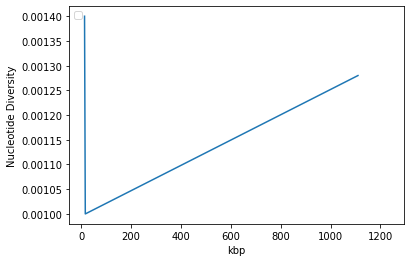

In [38]:
#plot
import matplotlib.pyplot as plt

y = vcf_sum.select('Nd/bp').collect()
x = vcf_sum.select('POS_BUCKET').collect()

plt.plot(x, y)

plt.ylabel('Nucleotide Diversity')
plt.xlabel('kbp')
plt.title('')
plt.legend('', loc='upper left')

plt.show()

In [129]:
from pyspark.sql.types import FloatType

#Group by bucket 
Hd = Hf.groupBy('POS_BUCKET')\
        .agg({'Hf2':'sum'})\
        .orderBy('POS_BUCKET')
        
def cal_Hd(sum_Hf2):
    #fix this not hard coded 
    N = 6
    return (N/(N-1)) * 1 - sum_Hf2

cal_hd_udf = udf(cal_Hd, FloatType())

Hd = Hd.withColumn('Hd', cal_hd_udf('sum(Hf2)'))
Hd.show()

+----------+--------------------+----------+
|POS_BUCKET|            sum(Hf2)|        Hd|
+----------+--------------------+----------+
|      14.0|                0.25|      0.95|
|      17.0|0.027777777777777776| 1.1722223|
|    1110.0|  0.5555555555555556|0.64444447|
|    1230.0|                 0.0|       1.2|
|    1234.0|  0.2777777777777778| 0.9222222|
+----------+--------------------+----------+



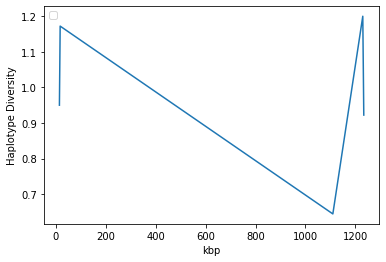

In [130]:
#plot
import matplotlib.pyplot as plt

y = Hd.select('Hd').collect()
x = Hd.select('POS_BUCKET').collect()

plt.plot(x, y)

plt.ylabel('Haplotype Diversity')
plt.xlabel('kbp')
plt.title('')
plt.legend('', loc='upper left')

plt.show()

# NUCLEOTIDE DIVERSITY 

In [382]:
import re 
from pyspark.sql.functions import udf

#Get names of sample columns 
columns = vcf.schema.names
columns = [x for x in columns if re.match("NA*", x)]

#loop through samples and get array of genotype information
for sample in columns: 
    vcf = vcf.withColumn(sample, split(col(sample), ":").cast(ArrayType(StringType())).alias(sample)[0])\
            .withColumn(sample, split(col(sample), "[|/]").cast(ArrayType(StringType())).alias(sample))
    
vcf.select('REF', 'ALT', 'NA00001', 'NA00002', 'NA00003').show()
vcf.printSchema()

+---+------+-------+-------+-------+
|REF|   ALT|NA00001|NA00002|NA00003|
+---+------+-------+-------+-------+
|  G|     A| [0, 0]| [1, 0]| [1, 1]|
|  T|     A| [0, 0]| [0, 1]| [0, 0]|
|  A|   G,T| [1, 2]| [2, 1]| [2, 2]|
|  T|     .| [0, 0]| [0, 0]| [0, 0]|
|GTC|G,GTCT| [0, 1]| [0, 2]| [1, 1]|
+---+------+-------+-------+-------+

root
 |-- #CHROM: string (nullable = true)
 |-- POS: integer (nullable = true)
 |-- ID: string (nullable = true)
 |-- REF: string (nullable = true)
 |-- ALT: string (nullable = true)
 |-- QUAL: string (nullable = true)
 |-- FILTER: string (nullable = true)
 |-- INFO: string (nullable = true)
 |-- FORMAT: string (nullable = true)
 |-- NA00001: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- NA00002: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- NA00003: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- POS_BUCKET: double (nullable = true)



In [304]:
from pyspark.sql.types import *
from pyspark.sql.functions import udf, struct
import re 

def split_allel(ALT, REF):
    res = ALT.split(',')
    res.insert(0, REF)
    return res

index_allel_udf = udf(split_allel, StringType())

vcf = vcf.withColumn('ALLELS_TOT', index_allel_udf('ALT', 'REF'))

vcf.select('REF', 'ALT', 'ALLELS_TOT', 'NA00001', 'NA00002', 'NA00003').show()

+---+------+--------------+-------+-------+-------+
|REF|   ALT|    ALLELS_TOT|NA00001|NA00002|NA00003|
+---+------+--------------+-------+-------+-------+
|  G|     A|        [G, A]| [0, 0]| [1, 0]| [1, 1]|
|  T|     A|        [T, A]| [0, 0]| [0, 1]| [0, 0]|
|  A|   G,T|     [A, G, T]| [1, 2]| [2, 1]| [2, 2]|
|  T|     .|        [T, .]| [0, 0]| [0, 0]| [0, 0]|
|GTC|G,GTCT|[GTC, G, GTCT]| [0, 1]| [0, 2]| [1, 1]|
+---+------+--------------+-------+-------+-------+



In [305]:
#count number of times each allel occurs 
def count_allel(sample, ALLELS_TOT):
    allel_count = []
    ALLELS_TOT = re.findall('[ATCG.]+', ALLELS_TOT)
    for index, allel in enumerate(ALLELS_TOT):
        allel_count.append(sample.count(index))
    
    return allel_count  
    
count_allel_udf = udf(count_allel, IntegerType())
vcf_count = vcf

for sample in columns:
    vcf_count = vcf_count.withColumn(sample, count_allel_udf(sample, 'ALLELS_TOT'))

vcf_count.select('REF', 'ALT', 'ALLELS_TOT', 'NA00001', 'NA00002', 'NA00003').show()
vcf_count.printSchema()

+---+------+--------------+-------+-------+-------+
|REF|   ALT|    ALLELS_TOT|NA00001|NA00002|NA00003|
+---+------+--------------+-------+-------+-------+
|  G|     A|        [G, A]|   null|   null|   null|
|  T|     A|        [T, A]|   null|   null|   null|
|  A|   G,T|     [A, G, T]|   null|   null|   null|
|  T|     .|        [T, .]|   null|   null|   null|
|GTC|G,GTCT|[GTC, G, GTCT]|   null|   null|   null|
+---+------+--------------+-------+-------+-------+

root
 |-- #CHROM: string (nullable = true)
 |-- POS: integer (nullable = true)
 |-- ID: string (nullable = true)
 |-- REF: string (nullable = true)
 |-- ALT: string (nullable = true)
 |-- QUAL: string (nullable = true)
 |-- FILTER: string (nullable = true)
 |-- INFO: string (nullable = true)
 |-- FORMAT: string (nullable = true)
 |-- NA00001: integer (nullable = true)
 |-- NA00002: integer (nullable = true)
 |-- NA00003: integer (nullable = true)
 |-- POS_BUCKET: double (nullable = true)
 |-- ALLELS_TOT: string (nullable = tr

In [285]:
#frequency of each allel in each polymorfic site 
Pf = vcf_count.withColumn('Pf', sum(vcf_count[sample] for sampel in columns)) 
Pf.select('Pf').show()

+----+
|  Pf|
+----+
|null|
|null|
|null|
|null|
|null|
+----+



In [206]:
df.printSchema()

root
 |-- #CHROM: string (nullable = true)
 |-- POS: integer (nullable = true)
 |-- ID: string (nullable = true)
 |-- REF: string (nullable = true)
 |-- ALT: string (nullable = true)
 |-- QUAL: string (nullable = true)
 |-- FILTER: string (nullable = true)
 |-- INFO: string (nullable = true)
 |-- FORMAT: string (nullable = true)
 |-- NA00001: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- NA00002: string (nullable = true)
 |-- NA00003: string (nullable = true)
 |-- POS_BUCKET: double (nullable = true)
 |-- ALLELS_TOT: string (nullable = true)



In [250]:
vcf.show()

+------+-------+---------+---+------+----+------+--------------------+-----------+--------------+--------------+------------+----------+
|#CHROM|    POS|       ID|REF|   ALT|QUAL|FILTER|                INFO|     FORMAT|       NA00001|       NA00002|     NA00003|POS_BUCKET|
+------+-------+---------+---+------+----+------+--------------------+-----------+--------------+--------------+------------+----------+
|    20|  14370|rs6054257|  G|     A|  29|  PASS|NS=3;DP=14;AF=0.5...|GT:GQ:DP:HQ|0|0:48:1:51,51|1|0:48:8:51,51|1/1:43:5:.,.|      14.0|
|    20|  17330|        .|  T|     A|   3|   q10| NS=3;DP=11;AF=0.017|GT:GQ:DP:HQ|0|0:49:3:58,50|  0|1:3:5:65,3|    0/0:41:3|      17.0|
|    20|1110696|rs6040355|  A|   G,T|  67|  PASS|NS=2;DP=10;AF=0.3...|GT:GQ:DP:HQ|1|2:21:6:23,27|  2|1:2:0:18,2|    2/2:35:4|    1110.0|
|    20|1230237|        .|  T|     .|  47|  PASS|     NS=3;DP=13;AA=T|GT:GQ:DP:HQ|0|0:54:7:56,60|0|0:48:4:51,51|    0/0:61:2|    1230.0|
|    20|1234567|microsat1|GTC|G,GTCT|  50

In [398]:
print(columns)

['NA00001', 'NA00002', 'NA00003']


In [18]:
spark_context.stop()

In [30]:
res = re.findall('[ATGC.]+', 'A,C')
list(range(0,len(res)+1))

[0, 1, 2]

In [33]:
def count_allel(GENOTYPES, ALT):
    #get number of allels 
    n = re.findall('[ATGC.]+', ALT)
    res = []
    for i in range(0,len(n)+1):
        res.append(GENOTYPES.count(str(i)))
    return res

count_allel('0|01|12|2', 'A,C')

[2, 2, 2]

In [45]:
x = [2, 2]
y = [y**2 for y in x]
z = [y-x for x, y in zip(x,y)]
sum(z)

4

In [8]:
spark_context.stop()